# NLP-Based Classification of Haitian Disaster Response Messages

## 1. Business understanding

In the immediate aftermath of the 2010 Haiti earthquake, humanitarian organizations received an overwhelming volume of crisis messages through SMS, social media, and community reports. These messages mixed urgent pleas for food, water, shelter, and medical aid with general updates, logistical inquiries, and non-actionable content. Manual triage was slow, inconsistent, and unsustainable under pressure. Without rapid prioritization, genuine requests for life-saving assistance risked being overlooked, delaying critical interventions and worsening outcomes for affected communities.

### 1.1 Stakeholders
#### a. Primary stakeholders  
- Humanitarian response teams (UN OCHA, Red Cross, local NGOs)  
- Affected communities in Haiti

#### b. Secondary stakeholders
- Technology partners
- Donors and policy makers

### 1.2 Success Criteria
The project is successful if the model meets the following criteria:  
- Macro F1-score ≥ 0.75: Balanced performance across `request` and `info` classes.  
- Recall for `request` ≥ 0.75: Capture at least three out of four urgent messages.  
- ROC-AUC ≥ 0.85: Strong ability to rank urgent messages above non-urgent ones.  
- Interpretability: Top predictive features must align with real-world humanitarian keywords (water, tent, baby, help).  
- Operational feasibility: Lightweight, fast, and deployable in low-resource environments.

## 2. Data collection and description

In [1]:
# core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nlp tools
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [2]:
# load messages dataset
messages = pd.read_csv("disaster_messages.csv")
print("Messages columns:", messages.columns.tolist())

Messages columns: ['id', 'message', 'original', 'genre']


In [3]:
# load categories dataset
cat = pd.read_csv("disaster_categories.csv")
print("Categories columns:", cat.columns.tolist())

Categories columns: ['id', 'categories']


The two files share a common id column.

### 2.1 Data source context and composition
The dataset originates from crowdsourced annotation efforts during three major disasters: the 2010 Haiti earthquake, Hurricane Sandy (2012), and the Nepal earthquake (2015). For this project, the scope is limited to Haiti-related direct messages only, as the operational goal is to support response efforts specific to the 2010 earthquake. This focus ensures contextual relevance and avoids dilution from unrelated global events.

In [4]:
# merge the datasets
df = messages.merge(cat, left_on='id', right_on='id', how='inner')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


## 3. Data understanding and preparation

In [5]:
# missing values
print("\nMissing values in dataset:\n", df.isnull().sum())

# duplicates
print(f"\nDuplicate message IDs: {df.duplicated(subset='id').sum()}")


Missing values in dataset:
 id                0
message           0
original      16140
genre             0
categories        0
dtype: int64

Duplicate message IDs: 206


In [6]:
# create a dataframe of the 36 individual category columns
categories = df["categories"].str.split(';', expand=True)

# extract category names from the first row
category_col = categories.iloc[0].str.split('-').str[0].tolist()
categories.columns = category_col

# convert category values to just numbers 0 or 1
for column in categories:
    categories[column] = categories[column].str[-1]
    
    categories[column] = pd.to_numeric(categories[column])

# drop the original categories column from `df`
df.drop(['categories'], axis=1, inplace = True)

# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1 Filter for Haiti related data

In [7]:
haiti_mask = (
    (df['genre'] == 'direct') |
    (df['original'].str.contains('Haiti', case=False, na=False)) |
    (df['message'].str.contains('Haiti', case=False, na=False))
)
df = df[haiti_mask].copy()

# keep only disaster-related messages
df = df[df["related"] == 1].reset_index(drop=True)

# remove duplicates (based on message + genre)
df = df.drop_duplicates(subset=['message', 'genre']).reset_index(drop=True)

In [8]:
conditions = [
    (df["request"] == 1),
    (df["request"] == 0)
]
choices = ["request", "info"]
df["target"] = np.select(conditions, choices, default="info")

target_percentages = df["target"].value_counts(normalize=True) * 100

In [9]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # lowercase
    text = text.lower()
    # remove URLs, mentions, hashtags, and special characters
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords and non-alphabetic tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stopwords.words('english')]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['clean_message'] = df['message'].apply(preprocess_text)

### 3.2 Exploratory statistics

In [10]:
df['word_count'] = df['clean_message'].str.split().str.len()
df['char_count'] = df['message'].str.len()

print("Average word count:", df['word_count'].mean())
print("Message length range:", df['char_count'].min(), "–", df['char_count'].max())

Average word count: 9.352490918526206
Message length range: 4 – 4102


### 3.3 Train-Test split

The data is split into training (80%) and test (20%) sets using stratified sampling to preserve the request/info class distribution in both subsets. This ensures reliable model evaluation and mitigates bias from class imbalance.

In [11]:
# train-test split (stratified)
X = df['clean_message']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 4. Exploratory text analysis

### Target distribution and message length

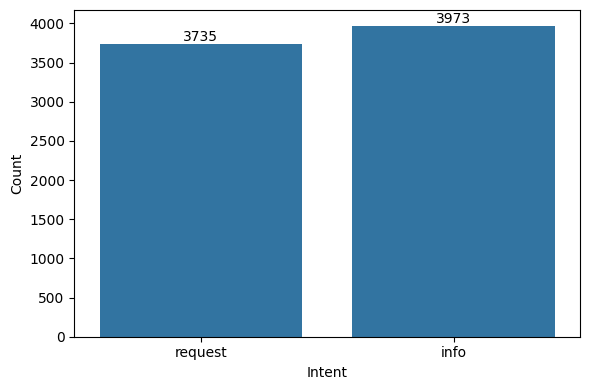

In [12]:
plt.figure(figsize=(6, 4))

# count values and set order
order = ['request', 'info']
counts = df['target'].value_counts().reindex(order, fill_value=0)

# create bar plot
ax = sns.barplot(x=counts.index, y=counts.values)

# add labels on top of each bar (container-based)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

# labels and title
plt.ylabel('Count')
plt.xlabel('Intent')
plt.tight_layout()
plt.show()

The dataset contains 3 973 messages classified as info and 3 735 classified as request and there's a slight imbalance in favor of informational content.

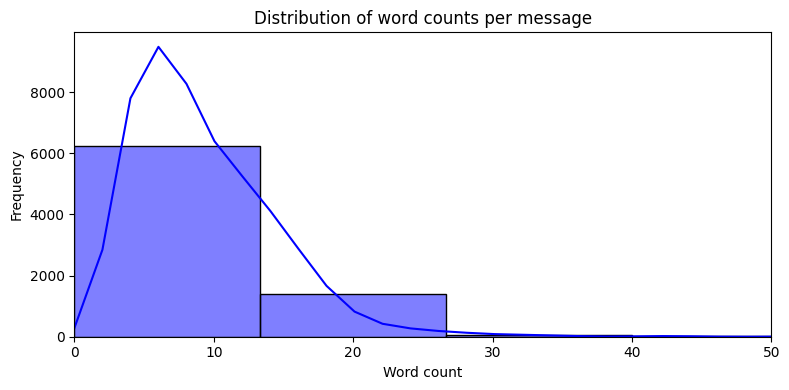

In [13]:
df['word_count'] = df['clean_message'].str.split().str.len()

plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of word counts per message')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

The distribution of word counts shows that the vast majority of messages are extremely short, with a peak around 5–10 words. The frequency declines rapidly beyond 15 words, and very few messages exceed 30 words.

### Top words

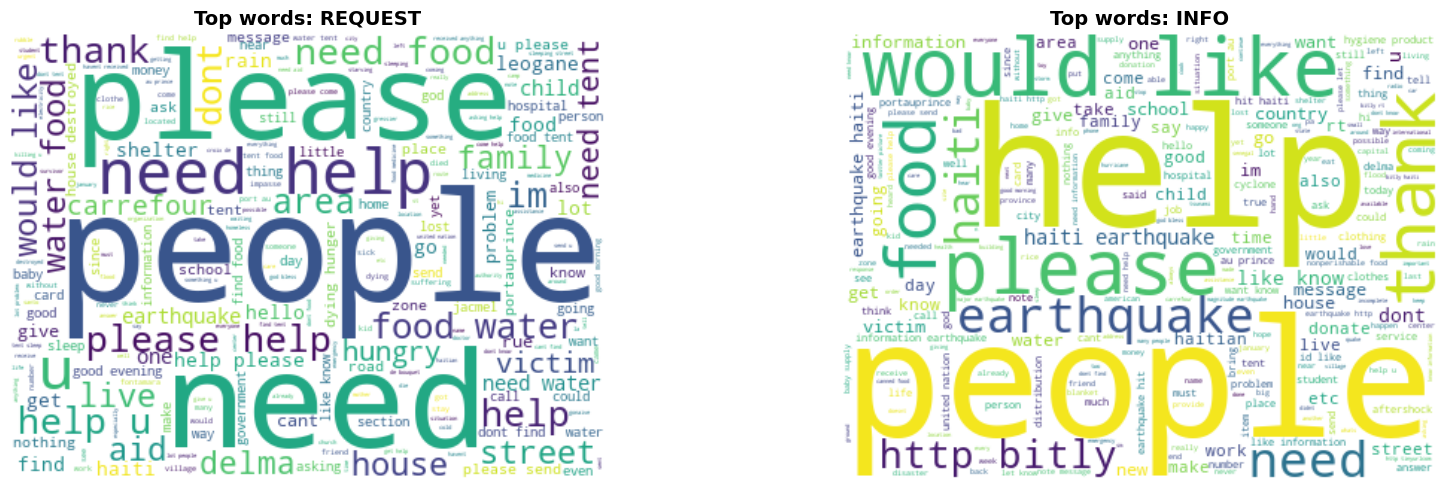

In [14]:
# function to generate word cloud
def plot_wordcloud(text, title, ax):
    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='viridis',
        max_words=500,
        stopwords=set(stopwords.words('english'))
    ).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# get text per class
request_text = ' '.join(df[df['target'] == 'request']['clean_message'])
info_text = ' '.join(df[df['target'] == 'info']['clean_message'])

# plot
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_wordcloud(request_text, 'Top words: REQUEST', axes[0])
plot_wordcloud(info_text, 'Top words: INFO', axes[1])

plt.tight_layout()
plt.show()

Word frequency analysis reveals distinct linguistic patterns between classes:
- request messages are dominated by urgent, need-oriented terms such as "need," "water," "food," "help," "shelter," "medicine," and "baby." These reflect immediate survival requirements.
- info messages feature more general or contextual language, including "haiti," "earthquake," "information," "know," "please," and "thank." These often convey updates, questions, or acknowledgments rather than direct appeals.

## 5. Modeling

### Problem definition
Although the original dataset supports multi-label classification (a message can simultaneously request food, water, and shelter), this project focuses on a binary intent classification task:
- request: messages that express an urgent need for aid
- info: all other messages (including offers, updates, and neutral statements)

### Model selection

Three interpretable and scalable models will be evaluated:

- Logistic Regression: Primary baseline, linear, transparent, and well-suited for text with class_weight='balanced' to handle imbalance.
- Multinomial Naive Bayes: Fast probabilistic alternative, effective for high-dimensional sparse text.
- Random Forest: Non-linear ensemble method, used to assess whether complex patterns improve performance.

In this Notebook version, we will be running our baseline model only.

In [15]:
# create pipelines
def make_pipeline(clf):
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=7000,
            ngram_range=(1, 3),
            sublinear_tf=True,
            min_df=2,
            max_df=0.95,
            stop_words='english'
        )),
        ('clf', clf)
    ])

# define models
models = {
    'Logistic Regression': make_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
}

### Model training

In [16]:
# train all models
for name, pipe in models.items():
    pipe.fit(X_train, y_train)

### Hyperparameter tuning
Logistic Regression undergoes hyperparameter tuning via 3-fold cross-validation, in order to optimize for macro F1-score to ensure fair performance across both classes

In [17]:
param_grid = {
    'tfidf__max_features': [5000, 7000],
    'tfidf__ngram_range': [(1, 3)],  # compare bigrams vs trigrams
    'clf__C': [0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(
    models['Logistic Regression'],
    param_grid,
    cv=3,
    scoring='f1_macro',  # balances performance across imbalanced classes
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
grid_search.best_params_
grid_search.best_score_

# use best estimator for final evaluation
best_lr = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


## 6. Evaluation

In [18]:
models = models.copy()
models['Logistic Regression (Tuned)'] = best_lr

results = []

for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # prob of 'request'
    y_test_int = (y_test == 'request').astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test_int, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 5),
        'Macro F1': round(f1_macro, 5),
        'ROC-AUC': round(auc, 5)
    })

# display comparison
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                      Model  Accuracy  Macro F1  ROC-AUC
        Logistic Regression   0.77108   0.77085  0.86270
Logistic Regression (Tuned)   0.77302   0.77272  0.86245


In [19]:
# generate predictions from the tuned Logistic Regression model
y_pred_tuned = best_lr.predict(X_test)

# generate classification report as a DataFrame
report = classification_report(y_test, y_pred_tuned, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# display key metrics rounded to 5 decimal places
print("Classification Report: Tuned Logistic Regression")
print(report_df[['precision', 'recall', 'f1-score']].round(5))

Classification Report: Tuned Logistic Regression
              precision   recall  f1-score
info            0.77709  0.78491   0.78098
request         0.76861  0.76037   0.76447
accuracy        0.77302  0.77302   0.77302
macro avg       0.77285  0.77264   0.77272
weighted avg    0.77298  0.77302   0.77298


### Confusion matrix

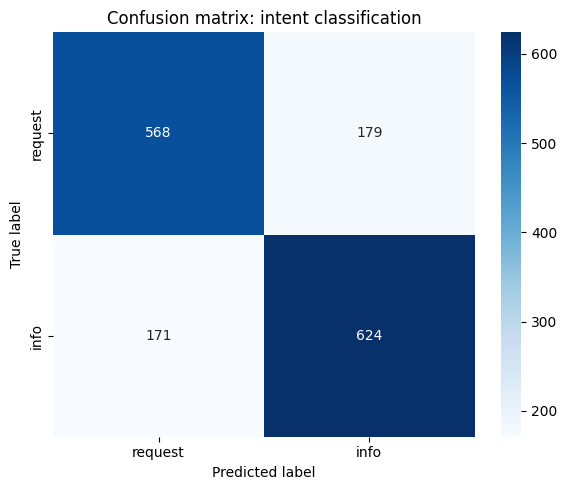

In [20]:
# generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['request', 'info'])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['request', 'info'],
    yticklabels=['request', 'info']
)
plt.title('Confusion matrix: intent classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The model correctly identified 568 urgent requests and 624 informational messages. At the same time, it misclassified 179 true requests as informational and flagged 171 informational messages as urgent. These errors are nearly balanced, which indicates the model does not favor one class over the other. This balance is essential for fair and effective crisis response.

### ROC-AUC analysis

ROC-AUC (binary): 0.862


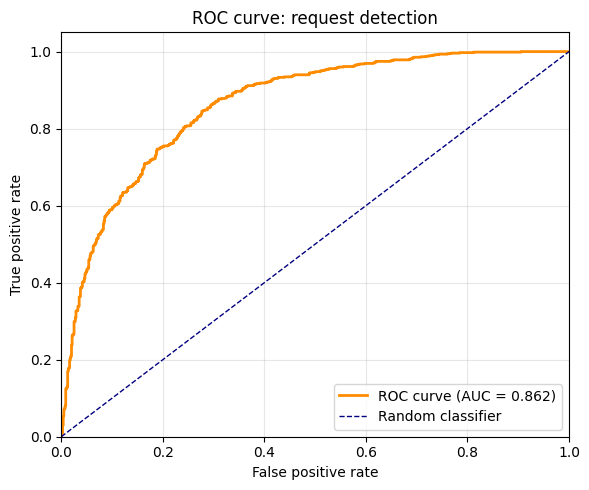

In [21]:
# get predicted probabilities
y_proba = best_lr.predict_proba(X_test)

# map labels
label_map = {'info': 0, 'request': 1}
y_test_int = y_test.map(label_map).values
y_proba_positive = y_proba[:, 1]

# compute ROC-AUC
roc_auc = roc_auc_score(y_test_int, y_proba_positive)
print(f"ROC-AUC (binary): {roc_auc:.3f}")
fpr, tpr, _ = roc_curve(y_test_int, y_proba_positive)  # ← use roc_curve, not auc!

# plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: request detection')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()